In [2]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight





from xgboost import XGBClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [3]:
def get_data(ticker, start_date='2018-01-01', end_date='2025-07-15', save_csv=False):
    os.makedirs("data", exist_ok=True)
    filename = f"data/{ticker.lower()}.csv"
    # if os.path.exists(filename):
    #     print(f"Data for {i} already exists, skipping download.")
    #     continue

    data = yf.download(ticker.upper(), start=start_date, end=end_date, auto_adjust=True)

    # Handle empty or failed download
    if data.empty:
        print(f"No data found for {ticker}")
        return pd.DataFrame()
    
    # Flatten column headers if it's a MultiIndex (e.g., from group_by='ticker')
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    
    data.reset_index(inplace=True)
    data['Ticker'] = ticker.lower()
    data['Date'] = pd.to_datetime(data['Date'])
    data.columns = [col.lower() for col in data.columns]


    if save_csv:
        data.to_csv(filename, index=False)
        print(f"Saved data for {ticker} to {filename}")
        
    return data

In [4]:
# targets: PLTR, SPOT, XOM

tickers = ['pltr', 'spot', 'xom', 'nvda']
dfs = {i: None for i in tickers}
start_dates = {
    'pltr': '2020-09-30',
    'spot': '2018-04-03',
    'xom': '2018-01-01',  # only going to use data from 2018 onwards
    'nvda': '1900-01-01' # get all
}

for i in tickers:
    dfs[i] = get_data(i, start_date=start_dates.get(i,'1900-01-01'), save_csv=True)

[*********************100%***********************]  1 of 1 completed


Saved data for pltr to data/pltr.csv


[*********************100%***********************]  1 of 1 completed


Saved data for spot to data/spot.csv


[*********************100%***********************]  1 of 1 completed


Saved data for xom to data/xom.csv


[*********************100%***********************]  1 of 1 completed

Saved data for nvda to data/nvda.csv


In [5]:
for idx, i in dfs.items():
    print(f"{idx.upper()} shape: {i.shape}")

PLTR shape: (1201, 7)
SPOT shape: (1830, 7)
XOM shape: (1892, 7)
NVDA shape: (6659, 7)


In [6]:
pd.concat([dfs['pltr'].head(), dfs['pltr'].tail()])

,date,close,high,low,open,volume,ticker
0,2020-09-30,9.500000,11.410000,9.110000,10.000000,338584400,pltr
1,2020-10-01,9.460000,10.100000,9.230000,9.690000,124297600,pltr
2,2020-10-02,9.200000,9.280000,8.940000,9.060000,55018300,pltr
3,2020-10-05,9.030000,9.490000,8.920000,9.430000,36316900,pltr
4,2020-10-06,9.900000,10.180000,8.900000,9.040000,90864000,pltr
1196,2025-07-08,139.710007,139.854996,135.789993,138.774994,59834800,pltr
1197,2025-07-09,143.130005,143.169998,137.389999,139.654999,68494800,pltr
1198,2025-07-10,142.500000,145.160004,139.529999,143.309998,64383900,pltr
1199,2025-07-11,142.100006,144.580002,141.470001,142.110001,52134800,pltr
1200,2025-07-14,149.149994,149.574997,142.220001,142.720001,81774400,pltr


In [11]:
# macro tickers
tickers_macro = ['spy', 'qqq', '^vix', 'cl=f', '^tnx']
dfs_macro = {i: None for i in tickers_macro}
for i in tickers_macro:
    dfs_macro[i] = get_data(i,start_date='1900-01-01', save_csv=True)

[*********************100%***********************]  1 of 1 completed


Saved data for spy to data/spy.csv


[*********************100%***********************]  1 of 1 completed


Saved data for qqq to data/qqq.csv


[*********************100%***********************]  1 of 1 completed


Saved data for ^vix to data/^vix.csv


[*********************100%***********************]  1 of 1 completed


Saved data for cl=f to data/cl=f.csv


[*********************100%***********************]  1 of 1 completed

Saved data for ^tnx to data/^tnx.csv


In [12]:
for idx, i in dfs_macro.items():
    print(f"{idx.upper()} shape: {i.shape}")

SPY shape: (8169, 7)
QQQ shape: (6627, 7)
^VIX shape: (8948, 7)
CL=F shape: (6248, 7)
^TNX shape: (15896, 7)


In [13]:
pd.concat([dfs_macro['spy'].head(), dfs_macro['spy'].tail()])

,date,close,high,low,open,volume,ticker
0,1993-01-29,24.380434,24.397774,24.276392,24.397774,1003200,spy
1,1993-02-01,24.553854,24.553854,24.397791,24.397791,480500,spy
2,1993-02-02,24.605869,24.623210,24.484487,24.536508,201300,spy
3,1993-02-03,24.865973,24.883313,24.623208,24.640549,529400,spy
4,1993-02-04,24.970018,25.022039,24.675233,24.952678,531500,spy
8164,2025-07-08,620.340027,622.109985,619.520020,621.349976,59024600,spy
8165,2025-07-09,624.059998,624.719971,620.909973,622.770020,66113300,spy
8166,2025-07-10,625.820007,626.869995,623.010010,624.200012,57529000,spy
8167,2025-07-11,623.619995,624.859985,621.530029,622.739990,63670200,spy
8168,2025-07-14,624.809998,625.159973,621.799988,623.159973,51898500,spy


# from the assingments 

In [9]:
import warnings
warnings.simplefilter('ignore')


import fAux
import mc_permutation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer 
from sklearn import preprocessing
import phik
from phik.report import plot_correlation_matrix
from scipy.special import ndtr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import FunctionTransformer
import ta
from ta.trend import EMAIndicator 
import detrendPrice 
global global_returns
global global_labels

np.random.seed(2) #to fix the results
rs = 2

def search_sequence_numpy(arr,seq):
    """ Find sequence in an array using NumPy only.

    Parameters
    ----------    
    arr    : input 1D array
    seq    : input 1D array

    Output
    ------    
    Output : 1D Array of indices in the input array that satisfy the 
    matching of input sequence in the input array.
    In case of no match, an empty list is returned.
    https://stackoverflow.com/questions/36522220/searching-a-sequence-in-a-numpy-array
    https://archive.is/GBCln
    """
    
    # Store sizes of input array and sequence
    Na, Nseq = arr.size, seq.size

    # Range of sequence
    r_seq = np.arange(Nseq)

    # Create a 2D array of sliding indices across the entire length of input array.
    # Match up with the input sequence & get the matching starting indices.
    M = (arr[np.arange(Na-Nseq+1)[:,None] + r_seq] == seq).all(1)

    # Get the range of those indices as final output
    if M.any() >0:
        return np.where(np.convolve(M,np.ones((Nseq),dtype=int))>0)[0]
    else:
        return []         # No match found



def mean_return(y_true, y_pred):
    #this function has access to two global variables (global_labels and global_returns)
    #to help in the calculation of the model returns (multiplying mkt returns by positions derived from y_pred)
    #search_sequence_numpy searches for the index ix of the global_labels that correspond to the sequence of true lables (y_true)
    #those ix are then used to obtain the mkt returns that need to be multiplied by the positions to obtain the model returns

    ix = search_sequence_numpy(global_labels.values.flatten(), y_true) 
    mkt_returns = global_returns.values[ix] # alternative to global_returns.values[ix[0]:ix[0]+y_true.size]
    mkt_returns = mkt_returns.flatten()
    
    positions = np.where(y_pred> 0,1,-1 )
    positions = np.nan_to_num(positions, nan=0.0)
    dailyRet = positions * mkt_returns
    dailyRet = np.nan_to_num(dailyRet, nan=0.0)
    
    #val_model_returns.append(dailyRet)
    #mean_return = gmean(dailyRet+1)-1 #will use log returns instead beause...
    dailyRet = np.log(dailyRet+1)
    mean_return = np.mean(dailyRet) #GridSearchCV and RandomSearchCV use arithmetic mean
    return mean_return

def profit_ratio(y_true, y_pred):
    
    ix = search_sequence_numpy(global_labels.values.flatten(), y_true) 
    mkt_returns = global_returns.values[ix] # alternative to global_returns.values[ix[0]:ix[0]+y_true.size]
    mkt_returns = mkt_returns.flatten()
    
    positions_arr = np.where(y_pred> 0,1,-1 )
    positions_arr = np.nan_to_num(positions_arr, nan=0.0)
    dailyRet_arr = positions_arr * mkt_returns #calculate the daily returns of the system
    dailyRet_arr = np.nan_to_num(dailyRet_arr, nan=0.0)
    profits = np.where((dailyRet_arr >= 0), dailyRet_arr, 0)
    losses = np.where((dailyRet_arr < 0), dailyRet_arr, 0)
    profit_ratio = np.sum(profits)/np.sum(np.abs(losses))
    return profit_ratio


def phi_k(y_true, y_pred):
    dfc = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    try:
        phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
        phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
        phi_k_p_val = 1 - ndtr(phi_k_sig) 
    except:
        phi_k_corr = 0
        phi_k_p_val = 0
    #print(phi_k_corr)
    print(phi_k_p_val)
    return phi_k_corr

#PANDAS exponential smoothing:
def pandas_ewm_smoother(x_train, span=None):
    x_train = pd.DataFrame(x_train)
    x_train_smooth = x_train.ewm(span=span, adjust=True).mean()
    return  x_train_smooth.values

#Ta-lib exponential smoothing:
def talib_ewm_smoother(x_train, span=None):
    w = np.arange(x_train.shape[0])
    for i in range(0,x_train.shape[1]):
        # a = ta.EMA(x_train[:,i], timeperiod=span)
        a = EMAIndicator(close=x_train[:,i], window=span).ema_indicator().values
        w = np.c_[w,a]
    return w[:,1:]

myscorer = None #use default accuracy score
#myscorer = make_scorer(mean_return, greater_is_better=True)
#myscorer = make_scorer(profit_ratio, greater_is_better=True)
#myscorer = make_scorer(phi_k, greater_is_better=True)

#when using smoother, use TimesSeriesSplit
n_splits = 5
#split = 5 
#split = TimeSeriesSplit(n_splits=5, max_train_size=2000) #fixed size window
split = TimeSeriesSplit(n_splits=n_splits)


#smoother = FunctionTransformer(talib_ewm_smoother)
smoother = FunctionTransformer(pandas_ewm_smoother)

# SPOT

## some ideas:
1. (most simple) will it close higher tmrw? -> binary classification (logistic reg, random forest, xgb)
2. what would the return be like over the next three days -> regression
3. will it outperform the s&p500 over the next five days
4. predict price direction after earning reports (may also introduce several other companies & their earning report dates and performance)


## brainstorm
- explicitly define the time horizon upfront
    - let's start off with: Swing Trading 
        - hodling period: days to weeks 
        - taraget example: return in 1-10 dyas 
        - suitable features: daily candles, TA indicators, moving average 
## pipeline and steps for swing trading using SPOT:
0. define the objective (e.g., predict if SPOT will rise in the next N days (e.g., 5-day return > 1%))
    - swing trading: holding 3-10 days
    - trade at opening (no intra day trading yet-advanced)
    - data: daily OHLCV + engineered TA features 
    - model type: binary classifier (0: no trade, 1: go long)
1. load and preprocess data
    - SPOT daily OHLCV
2. feature engineering (technical indicators)
    - trend: returns, SMA (10/50/200), EMA slope
    - momentum: RSI(14), MACD, stochastics 
    - volatility: ATR, bollinger band width
    - candle patterns: bullish/bearish engulfing, hammer, etc.
    - support/resistance proximity (optional)
3. define target variable   
    e.g.   
    `df['future_return_5d'] = (df['close'].shift(-5) - df['close']) / df['close']`  
    `df['target'] = (df['future_return_5d'] > 0.01).astype(int)`  
4. split train/test and normalize 
5. train ML model
6. predict & evaluate 
7. backtest
8. white reality check & monte carlo simulation 

### other consideration
- 1 stock or many stock? 
    - 1 stock -> proof of concept; quick iteration and backtesting; model learns idiosyncratic behaviour 
    - multiple stocks -> robustness across different assets; training on more diverse patterns; generalization to unseen assets; use ticker as a caotegorical features (optional)

In [10]:
spotdf = dfs['spot']
print(spotdf.shape)
pd.concat([spotdf.head(), spotdf.tail()])

(1830, 7)


,date,close,high,low,open,volume,ticker
0,2018-04-03,149.009995,169.000000,148.259995,165.899994,30526500,spot
1,2018-04-04,144.220001,148.929993,135.509995,140.000000,11702900,spot
2,2018-04-05,143.990005,152.410004,141.250000,149.229996,7372800,spot
3,2018-04-06,147.919998,148.729996,144.669998,146.070007,4228100,spot
4,2018-04-09,150.000000,151.000000,148.589996,149.500000,2051400,spot
1825,2025-07-08,721.390015,743.989990,709.989990,738.450012,1774500,spot
1826,2025-07-09,722.119995,731.979980,713.500000,722.440002,1362400,spot
1827,2025-07-10,709.950012,726.823975,699.000000,720.570007,1337800,spot
1828,2025-07-11,709.150024,714.099976,699.825012,709.000000,1267500,spot
1829,2025-07-14,717.489990,723.869995,707.150024,711.890015,1256700,spot


In [11]:
spotdf = dfs['spot'].copy()

# Data preparation 
spotdf['date'] = pd.to_datetime(spotdf['date'])
spotdf['month'] = spotdf['date'].dt.month
spotdf['dayofweek'] = spotdf['date'].dt.dayofweek
# You can drop 'date' after this if not needed

# save the close and open for white reality check
openp = spotdf['open'].copy() #for the case we want to enter trades at the open
closep = spotdf['close'].copy() #for the case we want to enter trades at the close

# Feature engineering with original data
# build the best window features after the exploratory data analysis:
for n in list(range(1,21)):
    name = 'ret' + str(n)
    spotdf[name] = spotdf["open"].pct_change(periods=n) #for trading with open
    #spotdf[name] = spotdf["close"].pct_change(periods=n) #for trading with close

#build target assuming we know today's open
spotdf['retFut1'] = spotdf['open'].pct_change(1).shift(-1).fillna(0) #if you enter the trade immediately after the open
#spotdf['retFut1'] = spotdf['close'].pct_change(1).shift(-1) #if you wait until the close to enter the trade
# spotdf = np.log(spotdf+1)

#transform the target
spotdf['retFut1_categ'] = np.where((spotdf['retFut1'] > 0), 1, 0)

# Since we are trading right after the open, 
# we only know yesterday's  high low close volume etc.
spotdf['high'] = spotdf['high'].shift(1)
spotdf['low'] = spotdf['low'].shift(1)
spotdf['close'] = spotdf['close'].shift(1)
spotdf['volume'] = spotdf['volume'].shift(1)
# spotdf['<SPREAD>'] = spotdf['<SPREAD>'].shift(1)

#select the features (by dropping)
# cols_to_drop = ["<OPEN>","<HIGH>","<LOW>","<CLOSE>","<TICKVOL>","<VOL>","<SPREAD>"]  #optional
# df_filtered = df.drop(cols_to_drop, axis=1)

print(spotdf.shape)

(1830, 31)


In [12]:
# add more technical features

# 1. trend features 
# Simple Moving Averages (10, 50, 200)
spotdf['sma10'] = spotdf['close'].rolling(10).mean()
spotdf['sma50'] = spotdf['close'].rolling(50).mean()
spotdf['sma200'] = spotdf['close'].rolling(200).mean()

# Exponential Moving Average Slope
ema = spotdf['close'].ewm(span=20, adjust=False).mean()
spotdf['ema_slope'] = ema.diff()


# 2. momentum features
# RSI (14)
spotdf['rsi'] = ta.momentum.RSIIndicator(close=spotdf['close'], window=14).rsi()

# MACD
macd = ta.trend.MACD(close=spotdf['close'])
spotdf['macd'] = macd.macd()
spotdf['macd_signal'] = macd.macd_signal()

# Stochastic Oscillator
stoch = ta.momentum.StochasticOscillator(high=spotdf['high'], low=spotdf['low'], close=spotdf['close'])
spotdf['stoch_k'] = stoch.stoch()
spotdf['stoch_d'] = stoch.stoch_signal()


# 3. volatility features
# ATR (Average True Range)
atr = ta.volatility.AverageTrueRange(high=spotdf['high'], low=spotdf['low'], close=spotdf['close'])
spotdf['atr'] = atr.average_true_range()

# Bollinger Band Width
bb = ta.volatility.BollingerBands(close=spotdf['close'], window=20, window_dev=2)
spotdf['bb_width'] = bb.bollinger_wband()


# 4. candle patterns
# bullish engulfing pattern
# Yesterday's open/close
o1 = spotdf['open'].shift(1)
c1 = spotdf['close'].shift(1)

# Today's open/close
o2 = spotdf['open']
c2 = spotdf['close']

# Bullish engulfing condition
spotdf['bull_engulf'] = (c1 < o1) & (c2 > o2) & (c2 > o1) & (o2 < c1)

In [13]:
print(f'original shape: {spotdf.shape}')

spotdf.dropna(inplace=True) #drop rows with NaN values
print(f'shape after dropping NaN values: {spotdf.shape}')
spotdf.head()

original shape: (1830, 43)
shape after dropping NaN values: (1630, 43)


,date,close,high,low,open,volume,ticker,month,dayofweek,ret1,...,sma200,ema_slope,rsi,macd,macd_signal,stoch_k,stoch_d,atr,bb_width,bull_engulf
200,2019-01-17,134.250000,134.559998,130.149994,133.020004,2152200.0,spot,1,3,0.007575,...,158.863801,1.211560,62.172847,0.178948,-2.753112,98.806324,96.341159,6.807334,24.168691,False
201,2019-01-18,133.250000,135.350006,132.529999,135.000000,1372400.0,spot,1,4,0.014885,...,158.785001,1.000935,60.781419,0.934223,-2.015645,92.152446,95.465495,6.522525,26.503931,False
202,2019-01-22,133.660004,136.000000,132.580002,132.610001,1314100.0,spot,1,1,-0.017704,...,158.732201,0.944656,61.165174,1.548022,-1.302911,91.462984,94.140585,6.300916,28.543147,False
203,2019-01-23,133.800003,134.770004,131.759995,134.199997,1255600.0,spot,1,2,0.011990,...,158.681251,0.868022,61.304408,2.022447,-0.637840,91.973744,91.863058,6.065852,29.899835,False
204,2019-01-24,130.919998,135.500000,128.535004,131.000000,1159400.0,spot,1,3,-0.023845,...,158.596251,0.511067,56.793387,2.141355,-0.082001,81.466614,88.301114,6.130076,28.692342,False


In [14]:
X = spotdf.drop(columns=['date', 'retFut1', 'retFut1_categ', 'ticker'])  # or keep 'date' if needed
y = spotdf['retFut1_categ']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [15]:
# check
assert not X_train.isnull().any().any()
assert np.isfinite(X_train).all().all()


In [16]:
# baseline model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(f'class distribution in y_train: {y_train.value_counts(normalize=True)}')
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

class distribution in y_train: retFut1_categ
1    0.517638
0    0.482362
Name: proportion, dtype: float64
              precision    recall  f1-score   support

           0       0.49      0.72      0.58       152
           1       0.59      0.35      0.44       174

    accuracy                           0.52       326
   macro avg       0.54      0.53      0.51       326
weighted avg       0.54      0.52      0.51       326

Accuracy: 0.5214723926380368
[[109  43]
 [113  61]]


<Axes: >

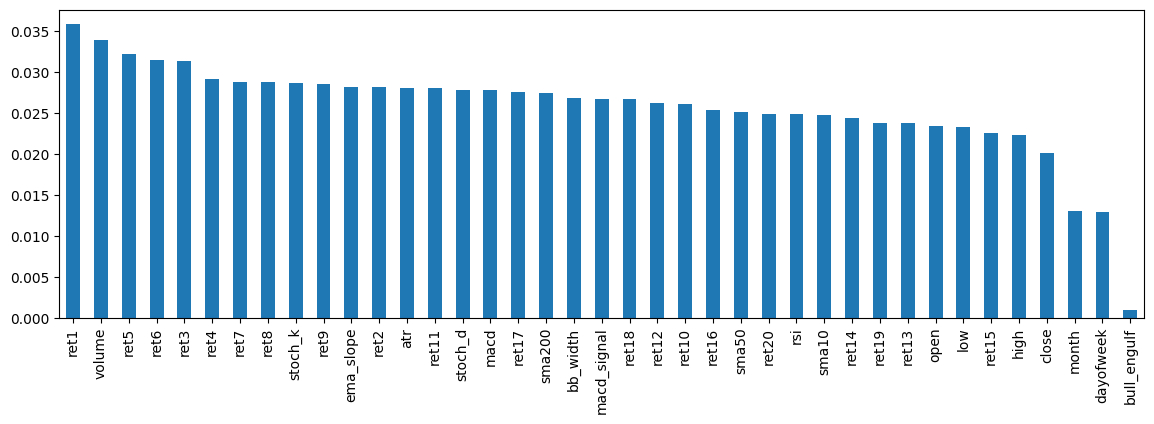

In [17]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(14, 4))

In [18]:
# xgb
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
print(classification_report(y_test, xgb.predict(X_test)))


              precision    recall  f1-score   support

           0       0.52      0.64      0.57       152
           1       0.60      0.48      0.54       174

    accuracy                           0.56       326
   macro avg       0.56      0.56      0.55       326
weighted avg       0.56      0.56      0.55       326



In [19]:
# check correlation between features and target
for i in X.columns:
    print(f'Correlation between {i} and retFut1_categ: {spotdf[i].corr(spotdf["retFut1_categ"])}')


Correlation between close and retFut1_categ: -0.0029315352279383994
Correlation between high and retFut1_categ: -0.0026893165052723758
Correlation between low and retFut1_categ: -0.0018288876060090545
Correlation between open and retFut1_categ: -0.004322923811070118
Correlation between volume and retFut1_categ: 0.003556406598646816
Correlation between month and retFut1_categ: -0.02104331357593899
Correlation between dayofweek and retFut1_categ: -0.016499362317288085
Correlation between ret1 and retFut1_categ: -0.04920881229612368
Correlation between ret2 and retFut1_categ: -0.028709464097196505
Correlation between ret3 and retFut1_categ: -0.034325636612794946
Correlation between ret4 and retFut1_categ: -0.025013894013894315
Correlation between ret5 and retFut1_categ: -0.045391318837975675
Correlation between ret6 and retFut1_categ: -0.03449051680305724
Correlation between ret7 and retFut1_categ: -0.024856747803968564
Correlation between ret8 and retFut1_categ: -0.010856174306639408
Cor

# above: bad as fuck!

# try NVDA instead of SPOT so that we'll have more data for LSTM

In [72]:
# change the target to five day returns
nvdalstm = dfs['nvda'].copy()
nvdalstm.drop(columns=['ticker'], inplace=True)  
print(nvdalstm.shape)

# Data preparation 
nvdalstm['date'] = pd.to_datetime(nvdalstm['date'])
nvdalstm['month'] = nvdalstm['date'].dt.month
nvdalstm['dayofweek'] = nvdalstm['date'].dt.dayofweek
# TODO: drop date in train test split

# save the close and open for white reality check
openp_lstm = nvdalstm['open'].copy() #for the case we want to enter trades at the open
closep_lstm = nvdalstm['close'].copy() #for the case we want to enter trades at the close


# build target assuming we know today's open
# nvdalstm['retFut1'] = nvdalstm['open'].pct_change(1).shift(-1).fillna(0)  # if you enter the trade immediately after the open
# transform the target
# nvdalstm['retFut1_categ'] = np.where((nvdalstm['retFut1'] > 0), 1, 0)

# update: let's predict close[t+5]
nvdalstm['retFut5'] = nvdalstm['close'].pct_change(5).shift(-5)
threshold = 0.01  # or 0.015 or 0.02
nvdalstm['bin_retFut5'] = (nvdalstm['retFut5'] > threshold).astype(int)
# nvdalstm.dropna(subset=['retFut5_categ'], inplace=True)


# lag features 
for lag in range(1,6):
    nvdalstm[f'lag{lag}'] = nvdalstm['close'].shift(lag)


# 1. trend features 
# Simple Moving Averages (10, 50, 200)
nvdalstm['sma10'] = nvdalstm['close'].rolling(10).mean()
nvdalstm['sma50'] = nvdalstm['close'].rolling(50).mean()
nvdalstm['sma200'] = nvdalstm['close'].rolling(200).mean()

# Exponential Moving Average Slope
ema = nvdalstm['close'].ewm(span=20, adjust=False).mean()
nvdalstm['ema_slope'] = ema.diff()

# ADD: % distance from SMA
nvdalstm['pct_sma10'] = (nvdalstm['close'] - nvdalstm['sma10']) / nvdalstm['sma10']

# 2. momentum features
# RSI (14)
nvdalstm['rsi'] = ta.momentum.RSIIndicator(close=nvdalstm['close'], window=14).rsi()

# MACD
macd = ta.trend.MACD(close=nvdalstm['close'])
nvdalstm['macd'] = macd.macd()
# nvdalstm['macd_signal'] = macd.macd_signal()
# nvdalstm['macd_hist'] = nvdalstm['macd'] - nvdalstm['macd_signal']

# Stochastic Oscillator
# stoch = ta.momentum.StochasticOscillator(high=nvdalstm['high'], low=nvdalstm['low'], close=nvdalstm['close'])
# nvdalstm['stoch_k'] = stoch.stoch()
# nvdalstm['stoch_d'] = stoch.stoch_signal()

# Williams %R
# nvdalstm['williams_r'] = ta.momentum.WilliamsRIndicator(high=nvdalstm['high'], low=nvdalstm['low'], close=nvdalstm['close'], lbp=14).williams_r()

# 3. volatility features
# ATR (Average True Range)
atr = ta.volatility.AverageTrueRange(high=nvdalstm['high'], low=nvdalstm['low'], close=nvdalstm['close'])
nvdalstm['atr'] = atr.average_true_range()

# Bollinger Band Width
# bb = ta.volatility.BollingerBands(close=nvdalstm['close'], window=20, window_dev=2)
# nvdalstm['bb_width'] = bb.bollinger_wband()

# Rolling Volatility (standard deviation of close returns over 10 days)
# nvdalstm['roll_vol'] = nvdalstm['close'].pct_change().rolling(10).std()

# Volume z-score
# nvdalstm['volume_z'] = (nvdalstm['volume'] - nvdalstm['volume'].rolling(20).mean()) / nvdalstm['volume'].rolling(20).std()

# 4. candle patterns
# bullish engulfing pattern
# Yesterday's open/close
# o1 = nvdalstm['open'].shift(1)
# c1 = nvdalstm['close'].shift(1)

# Today's open/close
# o2 = nvdalstm['open']
# c2 = nvdalstm['close']

# Bullish engulfing condition
# nvdalstm['bull_engulf'] = (c1 < o1) & (c2 > o2) & (c2 > o1) & (o2 < c1)

# 5. contextual market features (add after merge if SPY data is loaded separately)
# e.g., nvdalstm['spy_ret1'] = spy['close'].pct_change().shift(1)
# e.g., nvdalstm['vix_change'] = vix['close'].pct_change().shift(1)
spydf = dfs_macro['spy'].copy()
# Ensure SPY data is aligned on date
spydf['date'] = pd.to_datetime(spydf['date'])
spydf = spydf[['date', 'close']].rename(columns={'close': 'spy_close'})

# Merge SPY with nvdalstm on date
# nvdalstm = pd.merge(nvdalstm, spydf, on='date', how='left')

# Create SPY features with .shift(1) to avoid leakage
# nvdalstm['spy_ret1'] = nvdalstm['spy_close'].pct_change().shift(1)
# nvdalstm['spy_ret5'] = nvdalstm['spy_close'].pct_change(5).shift(1)
# nvdalstm['spy_roll_vol'] = nvdalstm['spy_close'].pct_change().rolling(10).std().shift(1)


#-----
# drop the first five rows for retFut5
nvdalstm.dropna(subset=['retFut5'], inplace=True)
# impute 
impute_feat = ['lag1', 'lag2', 'lag3', 'lag4', 'lag5','sma10', 'sma50', 'sma200', 
               'ema_slope', 'pct_sma10', 'rsi', 'macd']
for i in impute_feat:
    nvdalstm[i] = nvdalstm[i].ffill().bfill()

(6659, 6)


In [73]:
print(nvdalstm.shape)
print(nvdalstm.isna().sum())

(6654, 23)
date           0
close          0
high           0
low            0
open           0
volume         0
month          0
dayofweek      0
retFut5        0
bin_retFut5    0
lag1           0
lag2           0
lag3           0
lag4           0
lag5           0
sma10          0
sma50          0
sma200         0
ema_slope      0
pct_sma10      0
rsi            0
macd           0
atr            0
dtype: int64


In [74]:
# check class imbalance
# print(nvdalstm['retFut1_categ'].value_counts(normalize=True))
print(nvdalstm['bin_retFut5'].value_counts(normalize=True))

bin_retFut5
0    0.513075
1    0.486925
Name: proportion, dtype: float64


In [75]:
nvdalstm.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'month', 'dayofweek',
       'retFut5', 'bin_retFut5', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
       'sma10', 'sma50', 'sma200', 'ema_slope', 'pct_sma10', 'rsi', 'macd',
       'atr'],
      dtype='object')

In [76]:
sequence_length = 20
features = ['close', 'high', 'low', 'open', 'volume', 'month', 'dayofweek',
       'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'sma10', 'sma50', 'sma200', 
       'ema_slope', 'pct_sma10', 'rsi', 'macd', 'atr']  
X = []
y = []

for i in range(sequence_length, len(nvdalstm)):
    X.append(nvdalstm[features].iloc[i-sequence_length:i].values)
    y.append(nvdalstm['bin_retFut5'].iloc[i])  

X = np.array(X)
y = np.array(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# scaling
X_flat = X_train.reshape(-1, X_train.shape[-1])
scaler = StandardScaler().fit(X_flat)
X_train_scaled = scaler.transform(X_flat).reshape(X_train.shape)

# for test set too
X_test_flat = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)


class_weights = compute_class_weight('balanced', classes=np.array([0,1]), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
optimizer = Adam(learning_rate=0.0005)


# model = Sequential()
# model.add(LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))

# 2nd gen
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, 
                    epochs=20, 
                    batch_size=32, 
                    validation_split=0.2,
                    class_weight=class_weights_dict, 
                    callbacks=[lr_schedule],
                    shuffle=False
)


Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4942 - loss: 0.6955 - val_accuracy: 0.5113 - val_loss: 0.6952 - learning_rate: 5.0000e-04
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5299 - loss: 0.6921 - val_accuracy: 0.4887 - val_loss: 0.6965 - learning_rate: 5.0000e-04
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5388 - loss: 0.6907 - val_accuracy: 0.4991 - val_loss: 0.6977 - learning_rate: 5.0000e-04
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5449 - loss: 0.6871 - val_accuracy: 0.4868 - val_loss: 0.6992 - learning_rate: 5.0000e-04
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5592 - loss: 0.6842 - val_accuracy: 0.4962 - val_loss: 0.6997 - learning_rate: 2.5000e-04
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5579 - loss: 0.6827 - val_accuracy: 0.5028 - val_loss: 0.7005 - learning_rate: 2.5000e-04
Epoch 7/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc

In [81]:
y_val_pred = model.predict(X_train[int(len(X_train)*0.8):])  # using the validation portion from validation_split=0.2

print(f"Mean: {y_val_pred.mean():.4f}, Std: {y_val_pred.std():.4f}")


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Mean: 0.6390, Std: 0.0000


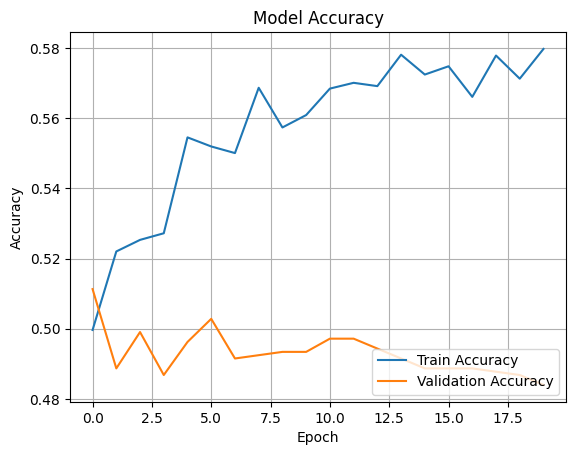

In [82]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [68]:
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5930 - loss: 0.6775
Test Accuracy: 0.5735


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Mean: 0.7217, Std: 0.0000


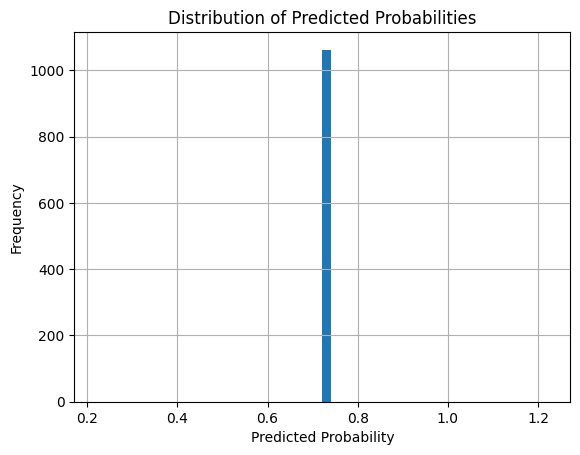

In [70]:
# Calculate split index
val_split = 0.2
split_index = int(len(X_train) * (1 - val_split))

# Create validation set manually
X_val = X_train[split_index:]
y_val = y_train[split_index:]

# Predict and analyze output distribution
y_val_pred_probs = model.predict(X_val)
print(f"Mean: {y_val_pred_probs.mean():.4f}, Std: {y_val_pred_probs.std():.4f}")

import matplotlib.pyplot as plt
plt.hist(y_val_pred_probs, bins=50)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [71]:
print("Positive class ratio:", np.mean(y_train))


Positive class ratio: 0.5409836065573771
